# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [24]:
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages

In [25]:
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
# !unzip lfw

In [26]:
import os
from glob import glob
import json
import numpy as np         
import matplotlib.pyplot as plt  
from tqdm import tqdm
import pandas as pd
import boto3
import sagemaker
import logging
from botocore.exceptions import ClientError

In [27]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F

In [28]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


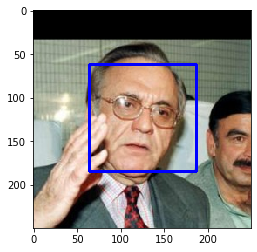

In [29]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[11])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [30]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [31]:
from tqdm import tqdm

human_files_short = human_files[:50]
dog_files_short = dog_files[:50]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

humans_detected_human_file = 0
humans_detected_dog_file = 0

for img in human_files_short:
    if face_detector(img):
        humans_detected_human_file += 1
        
for img in dog_files_short:
    if face_detector(img):
        humans_detected_dog_file += 1

        
print('Number of humans detected in human file:{}'.format(humans_detected_human_file))        
print('Number of humans detected in dog file:{}'.format(humans_detected_dog_file))

Number of humans detected in human file:50
Number of humans detected in dog file:5


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [32]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [33]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg16-397923af.pth


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

## Pytorch documentation state that: 

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:

In [34]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


def process_image(image):
    """Processes image to be input into a model for prediction.
    Scales, crops, and normalizes a PIL image for a PyTorch model.
        :param image: file path to the image file to be processed.
        :return: a tensor of the processed image.
    """
    if not os.path.exists(image):
        raise Exception('Image file could not be found')
    image = Image.open(image)
    
    # Augmentation Code
    image_norm = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(244),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])
    
    return image_norm(image)

In [35]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    Args:
        img_path: path to an image   
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    image = process_image(img_path)
    model = VGG16
    top_k = 1
    
    if torch.cuda.is_available():
        device = torch.device("cuda")
        model.to(device)
        image = image.to(device)
        
    else:
        model.cpu()
    model.eval()
    image = image.unsqueeze(0)
    
    with torch.no_grad():
        output = model(image)
        prediction = torch.argmax(output).item()
            
    return prediction

In [36]:
print(VGG16_predict('dogImages/train/103.Mastiff/Mastiff_06833.jpg'))

243


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [37]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    result = VGG16_predict(img_path)
    
    if result < 268 and result > 151:
        return True # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [38]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_files_short = human_files[:50]
dog_files_short = dog_files[:50]


humans_detected = 0
dogs_detected = 0

for img in human_files_short:
    if dog_detector(img):
        humans_detected += 1
        
for img in dog_files_short:
    if dog_detector(img):
        dogs_detected += 1


print('Number of humans detected in human file:{}'.format(humans_detected))     
print('Number of dogs detected in dog file:{}'.format(dogs_detected))


print("What percentage of the images in human_files_short have a detected dog? :{}%".format(humans_detected/len(human_files_short)*100))
print("What percentage of the images in dog_files_short have a detected dog? :{}%".format(dogs_detected/len(dog_files_short)*100))

Number of humans detected in human file:0
Number of dogs detected in dog file:50
What percentage of the images in human_files_short have a detected dog? :0.0%
What percentage of the images in dog_files_short have a detected dog? :100.0%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [39]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [40]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

def data_loader(base_folder='dogImages'):
    
    if not os.path.exists(base_folder):
        raise Exception('Target folder can not be found')  # raise exception is base_folder is not found
    
    valid_dir = base_folder + '/valid'
    valid_tranform = transforms.Compose([transforms.Resize(258),
                                        transforms.CenterCrop(244),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5),
                                                            (0.5, 0.5, 0.5))])
    valid_data = datasets.ImageFolder(valid_dir, transform=valid_tranform)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64)

    return {'valid': valid_loader}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- The images has been resized to 258 and center cropped to 244 to meet the Pytorch specification, also resizing will transfor all images to the same size, occupying less memory than is original format.



- Yes i did augmentation:
    - Randomized dataset for training.
    - Random rotation.
    - Random horizontal flips.

___

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

**Answer**:

- The model is cretaed  following the PROJECT PLAGIARISM DETECTION structure. 
    - 3 files were created inside source_pytorch. model.py, train.py, predict.py.

##  Creating a SageMaker session and specifying:

In [41]:
s3 = boto3.resource('s3')

# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

### Uploading the data to the S3 Bucket.

Specify the data_dir where you've saved your pictures file. Decide on a descriptive prefix that defines where your data will be uploaded in the default S3 bucket. Finally, create a pointer to your training data by calling sagemaker_session.upload_data and passing in the required parameters. It may help to look at the Session documentation or previous SageMaker code examples.

You are expected to upload your entire directory.

In [42]:
# should be the name of directory you created to save your features data
# data_dir = 'data_photos'

# set prefix, a descriptive name for a directory  
prefix = 'photos'

# upload all data to S3

# input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
# print(input_data)

The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.

In [43]:
# # set prefix, a descriptive name for a directory  
data_dir = 'dogImages'
prefix = 'photos'
# # upload all data to S3
# input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
input_data = "s3://" + bucket + "/"+prefix
print(input_data)

s3://sagemaker-us-east-1-429892070365/photos


###  Setting directories to work with S3

In [44]:
train_data_path = input_data + '/train/'
test_data_path = input_data + '/test/'
print(train_data_path)
print(test_data_path)

s3://sagemaker-us-east-1-429892070365/photos/train/
s3://sagemaker-us-east-1-429892070365/photos/test/


____

## Modeling 

### Define a custom PyTorch neural network classifier.


###### A typical training script:

- Loads training data from a specified directory
- Parses any training & model hyperparameters (ex. nodes in a neural network, training epochs, etc.)
- Instantiates a model of your design, with any specified hyperparams
- Trains that model
- Finally, saves the model so that it can be hosted/deployed, later

____

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

____

_Defining and training a model_

Almost all of your work will be done in the if __name__ == '__main__': section. To complete a train.py file, you will:

- Import any extra libraries you need
- Define any additional model training hyperparameters using parser.add_argument
- Define a model in the if __name__ == '__main__': section
- Train the model in that same section
- Below, you can use !pygmentize to display an existing train.py file. Read through the code; all of your tasks are marked with TODO comments.

Note: 
    - The model is in the model.py file. 
    - Predict scritp is in predict.py file

__Answer:__ 

 I took a similar step used in the VGG-16 model but simplified the network size as my aim is a lowly 10% accuracy.

- There are 3 convolution layers with the following architecture
    Convolution Layer1 -> In-channel:3 Out-channel:32 Kernel Size:3 stride:2 Padding:1
    Convolution Layer2 -> In-channel:32 Out-channel:64 Kernel Size:3 stride:2 Padding:1
    Convolution Layer3 -> In-channel:64 Out-channel:128 Kernel Size:3 Padding:1
- Maxpooling is applied with the Kernel Size:2 Stride:2
- 2 Fully-Connected Layers for the purpose of classifying the breed.
- Drop-out of 0.3 is applied to make sure there is no overfitting
- The activation function selected is ReLU activation function. This is applied to all the convolution layers.
- Learning rate is set as 0.05.

In [45]:
# directory can be changed to: source_sklearn or source_pytorch
!pygmentize source_pytorch/train.py

      
#####################################################################################################
                                            # Nuevo modelo
#####################################################################################################

import argparse
import json
import os
import pandas as pd
import torch
import torch.optim as optim
import torch.utils.data
import boto3
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from io import BytesIO

# imports the model in model.py by name
from model import Net


def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join

            valid_loss = 0
            for batch_idx, (data, target) in enumerate(valid_loader):

                inputs = data.to(device)
                target = target.to(device)
                    
                output_v = model(inputs)
                loss = criterion(output_v, target)
#                 valid_loss += loss.item()
                    
                # convert output probabilities to predicted class
                pred = output_v.data.max(1, keepdim=True)[1]
                # compare predictions to true label
                
                correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
                total += data.size(0)
                
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))
            print('Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
              

____

# Create an Estimator

When a custom model is constructed in SageMaker, an entry point must be specified. This is the Python file which will be executed when the model is trained; the `train.py` function you specified above. To run a custom training script in SageMaker, construct an estimator, and fill in the appropriate constructor arguments:

* **entry_point**: The path to the Python script SageMaker runs for training and prediction.
* **source_dir**: The path to the training script directory`source_pytorch`.
* **entry_point**: The path to the Python script SageMaker runs for training and prediction.
* **source_dir**: The path to the training script directory `train_pytorch`.
* **entry_point**: The path to the Python script SageMaker runs for training.
* **source_dir**: The path to the training script directory `train_pytorch`.
* **role**: Role ARN, which was specified, above.
* **train_instance_count**: The number of training instances (should be left at 1).
* **train_instance_type**: The type of SageMaker instance for training. Note: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* **sagemaker_session**: The session used to train on Sagemaker.
* **hyperparameters** (optional): A dictionary `{'name':value, ..}` passed to the train function as hyperparameters.

Note: For a PyTorch model, there is another optional argument **framework_version**, which you can set to the latest version of PyTorch, `1.5.0`.

In [46]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# specify an output path
# prefix is specified above
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train.py',
                    source_dir='source_pytorch', # this should be just "source" for your code
                    role=role,
                    framework_version='1.5.0',
                    py_version='py3',
                    instance_count=1,
                    instance_type='ml.c4.xlarge',
                    use_spot_instances = True,
                    max_run = 3600,
                    max_wait = 3600,
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={                
                        'epochs': 30 # could change to higher
                    })

### Test cell

Test that your data has been successfully uploaded. The below cell prints out the items in your S3 bucket and will throw an error if it is empty. You should see the contents of your `data_dir` and perhaps some checkpoints. If you see any other files listed, then you may have some old model files that you can delete via the S3 console (though, additional files shouldn't affect the performance of model developed in this notebook).

In [47]:
# confirm that data is in S3 bucket
empty_check = []
bucket = bucket
key = 'photos/train'

for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

Test passed!


## Train the estimator

Train your estimator on the training data stored in S3. This should create a training job that you can monitor in your SageMaker console.

In [36]:
%%time

# Train your estimator on S3 training data
estimator.fit({'train': train_data_path, 'test':test_data_path })

2020-11-26 22:33:37 Starting - Starting the training job...
2020-11-26 22:33:38 Starting - Launching requested ML instances...
2020-11-26 22:34:22 Starting - Insufficient capacity error from EC2 while launching instances, retrying!......
2020-11-26 22:35:10 Starting - Preparing the instances for training...
2020-11-26 22:36:01 Downloading - Downloading input data.........
2020-11-26 22:37:32 Training - Downloading the training image...
2020-11-26 22:37:53 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-11-26 22:37:53,993 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-11-26 22:37:53,996 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-11-26 22:37:54,007 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-11-26 22:37:54,011 sagemaker_pyto

Train Loss: 4.701933

Epoch: 2
Train Loss: 4.550845

Epoch: 3
Train Loss: 4.443501

Epoch: 4
Train Loss: 4.380454

Epoch: 5
Train Loss: 4.316167

Test Accuracy:  6% (57/836)
Training Loss: 4.316167 #011Validation Loss: 4.132666
Epoch: 6
Train Loss: 4.250694

Epoch: 7
Train Loss: 4.172791

Epoch: 8
Train Loss: 4.120388

Epoch: 9
Train Loss: 4.101095

Epoch: 10
Train Loss: 4.033072

Test Accuracy: 11% (98/836)
Training Loss: 4.033072 #011Validation Loss: 3.888259
Epoch: 11
Train Loss: 3.989346

Epoch: 12
Train Loss: 3.940033

Epoch: 13
Train Loss: 3.889109

Epoch: 14
Train Loss: 3.865309

Epoch: 15
Train Loss: 3.806094

Test Accuracy: 13% (111/836)
Training Loss: 3.806094 #011Validation Loss: 3.778117
Epoch: 16
Train Loss: 3.786058

Epoch: 17
Train Loss: 3.762690

Epoch: 18
Train Loss: 3.722639

Epoch: 19
Train Loss: 3.700667

Epoch: 20
Train Loss: 3.661826

Test Accuracy: 16% (134/836)
Training Loss: 3.661826 #011Validation Loss: 3.640126
Epoch: 21
Train Loss: 3.637686

Epoch: 22
Train 

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

- Initially I started out with a architecuture which took 32 px as input and had 3 convolutional layers and 2 fully connected layers, result was not as expected.
- After multiple experiments changing the input size and architecture of the model.  Finally with 224 px as input and 6 conv layers and 2 fully connected layers got a result that works.
- I have performed multiple experiments before arriving at the final architecture. 

____

## EXERCISE: Deploy the trained model

After training, deploy your model to create a `predictor`. We need to create a trained `PyTorchModel` that accepts the trained `<model>.model_data` as an input parameter and points to the provided `source_pytorch/predict.py` file as an entry point. 

To deploy a trained model, you'll use `<model>.deploy`, which takes in two arguments:
* **initial_instance_count**: The number of deployed instances (1).
* **instance_type**: The type of SageMaker instance for deployment.

In [48]:
%%time

# uncomment, if needed
from sagemaker.pytorch import PyTorchModel

# model = PyTorchModel(
#     entry_point="predict.py",
#     role=role, 
#     framework_version='1.5.0',
#     py_version='py3',
#     model_data=estimator.model_data,
#     source_dir="source_pytorch"
# )

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 15.5 µs


In [94]:
# print(estimator.model_data, "Model")

____

## Deploy your model to create a predictor.

In [95]:
# To deploy your model to create a predictor uncomment the line below
# predictor = model.deploy(initial_instance_count=2, instance_type="ml.t2.medium")

In [96]:
# predictor.endpoint_name

----
## EXERCISE: Clean up Resources

After you're done evaluating your model, **delete your model endpoint**. You can do this with a call to `.delete_endpoint()`. You need to show, in this notebook, that the endpoint was deleted. Any other resources, you may delete from the AWS console, and you will find more instructions on cleaning up all your resources, below.

In [97]:
# If you need to delete the endpoint uncomment the line below.  
# predictor.delete_endpoint()

### Getting dog names list by order.

In [ ]:
# confirm that data is in S3 bucket
dogs =[]
buckets = bucket +'/photos'
key = 'photos/train'

for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    if len(obj.key.split(".jpg")) > 1:
        a = obj.key.split(".jpg")[0].split(".")
        b = a[1].split("/")[0]
        dogs.append(b)

In [ ]:
clean_dog = list(set(dogs))
print("Dogs inside data {}". format(len(clean_dog)))
print("Dogs Breed {}".format(clean_dog))

###  The following cell attach a trained model to and Endpoint. 

Because I was working on different days I needed to delete the end point every time that I finished work on this project each day, otherwise I'll be charging per keep the endpoint alive. The following cell creates the new endpoint with the same model by attaching the name model, each time that we need it. 

In [26]:
my_training_job_name = "pytorch-training-2020-11-26-22-33-37-195"
pytorch_estimator = PyTorch.attach(my_training_job_name)


2020-11-26 23:29:06 Starting - Preparing the instances for training
2020-11-26 23:29:06 Downloading - Downloading input data
2020-11-26 23:29:06 Training - Training image download completed. Training in progress.
2020-11-26 23:29:06 Uploading - Uploading generated training model
2020-11-26 23:29:06 Completed - Training job completed


In [27]:
predictor = pytorch_estimator.deploy(initial_instance_count=2, instance_type="ml.t2.medium")

---------------------!

# Evaluating Your Model

Once your model is deployed, you can see how it performs when applied to our test data. The provided cell below, reads in the test data, assuming it is stored locally in `data_dir` and named `test`.

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy. Ensure that your test accuracy is greater than 10%.

- Answer: My best model accuracy was 25% in order to achieved this value NET was trained per over 300 epochs.

In [61]:
import itertools

def test(loaders):
    # monitor test loss and accuracy     
    tensor_predicted = []
    targets = []

    for batch_idx, (data, target) in enumerate(loaders['valid']):
        # forward pass: compute predicted outputs by passing inputs to the model
        targets.append(target.numpy().tolist())
        
        for each in data:
            tensor = predictor.predict(each[None , :])
            each = torch.from_numpy(tensor)
            
            # convert output probabilities to predicted class
            _, preds_tensor = torch.max(each, 1)
            tensor_predicted.append(preds_tensor.item())
        
    # report test accuracy
    targets = list(itertools.chain(*targets))
    
    # compare predictions to true label 
    test_accuracy = 100*np.sum(np.array(tensor_predicted)==np.array(targets))/len(tensor_predicted)
    print('Test accuracy: %.4f%%' % test_accuracy)

test(data_loader())

Test accuracy: 16.8862%



# Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)
You will now use transfer learning to create a CNN that can identify dog breed from images. Your CNN must attain at least 60% accuracy on the test set.

In [ ]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

## (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset
Use the code cell below to write three separate data loaders for the training, validation, and test datasets of dog images (located at dogImages/train, dogImages/valid, and dogImages/test, respectively).

If you like, you are welcome to use the same data loaders from the previous step, when you created a CNN from scratch.

In [ ]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
batch_size = 20                    
num_workers = 0

data_dir = 'dogImages' 
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')


#Here the augmentation of the data is done using RandomHorizontalFlip()
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]),
                   'valid': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])
                  }
# Create the loaders for the image
train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

training_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
testing_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)

# Here the image loader is constructed using the training_loader, validation_loader, testing_loader
loaders_scratch  = {
    'train': training_loader,
    'valid': validation_loader,
    'test': testing_loader
}
loaders_scratch

In [ ]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True)
model_transfer

In [ ]:
for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(2048, 133, bias=True)    
fc_parameters = model_transfer.fc.parameters()
model_transfer

## (IMPLEMENTATION) Specify Loss Function and Optimizer
Use the next code cell to specify a loss function and optimizer. Save the chosen loss function as criterion_transfer, and the optimizer as optimizer_transfer below.

In [ ]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.SGD(model_transfer.fc.parameters(), lr=0.001)

## (IMPLEMENTATION) Train and Validate the Model
Train and validate your model in the code cell below. Save the final model parameters at filepath 'model_transfer.pt'.

In [33]:
transfer_learning_training_loss = []
transfer_learning_validation_loss = []
# train the model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            transfer_learning_training_loss.append(train_loss)
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            transfer_learning_validation_loss.append(valid_loss)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

train(2, loaders_scratch, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


Epoch 1, Batch 1 loss: 4.979028
Epoch 1, Batch 101 loss: 4.903628
Epoch 1, Batch 201 loss: 4.869842
Epoch 1, Batch 301 loss: 4.832505
Epoch: 1 	Training Loss: 4.822577 	Validation Loss: 4.653606
Validation loss decreased (inf --> 4.653606).  Saving model ...
Epoch 2, Batch 1 loss: 4.714686
Epoch 2, Batch 101 loss: 4.664424
Epoch 2, Batch 201 loss: 4.632133
Epoch 2, Batch 301 loss: 4.606274
Epoch: 2 	Training Loss: 4.595810 	Validation Loss: 4.400115
Validation loss decreased (4.653606 --> 4.400115).  Saving model ...


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
model_transfer = torch.load('model_transfer.pt')

In [ ]:
test_loss_transfer = []
def test(loaders, model, criterion, use_cuda):
    # monitor test loss and accuracy 
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(loaders['valid']):
        # move to GPU
        
        #data, target = data.cuda(), target.cuda()
            
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        test_loss_transfer.append(test_loss)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label 
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

test(data_loader(), model_transfer, criterion_transfer, use_cuda)

In [42]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

from PIL import Image
import torchvision.transforms as transforms
import os

def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

def predict_breed_transfer(model, class_names, img_path):
    # load the image and return the predicted breed
    if os.path.isfile(img_path):
        img = load_input_image(img_path)
        model = model.cpu()
        model.eval()
        idx = torch.argmax(model(img))
        return clean_dog[idx]

for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    predition = predict_breed_transfer(model_transfer, clean_dog, img_path)
    print("image_file_name: {0}, \t predition breed: {1}".format(img_path, predition))


image_file_name: ./images/American_water_spaniel_00648.jpg, 	 predition breed: Gordon_setter
image_file_name: ./images/Curly-coated_retriever_03896.jpg, 	 predition breed: Keeshond
image_file_name: ./images/sample_human_output.png, 	 predition breed: American_eskimo_dog
image_file_name: ./images/sample_dog_output.png, 	 predition breed: Great_pyrenees
image_file_name: ./images/Labrador_retriever_06457.jpg, 	 predition breed: Greyhound
image_file_name: ./images/Welsh_springer_spaniel_08203.jpg, 	 predition breed: Irish_water_spaniel
image_file_name: ./images/Labrador_retriever_06449.jpg, 	 predition breed: Newfoundland
image_file_name: ./images/.ipynb_checkpoints, 	 predition breed: None
image_file_name: ./images/Labrador_retriever_06455.jpg, 	 predition breed: Kerry_blue_terrier
image_file_name: ./images/Brittany_02625.jpg, 	 predition breed: Great_pyrenees


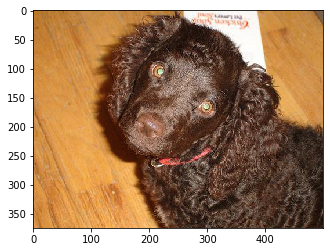

Dogs Detected!
It looks like a Gordon_setter


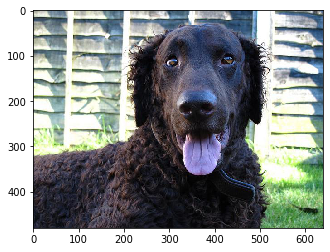

Dogs Detected!
It looks like a Keeshond


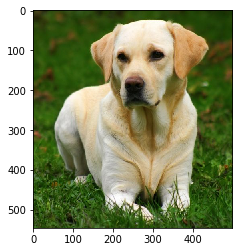

Dogs Detected!
It looks like a Greyhound


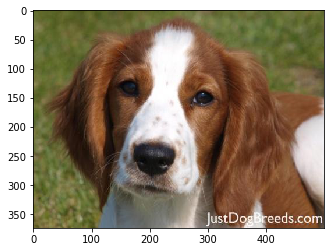

Dogs Detected!
It looks like a Irish_water_spaniel


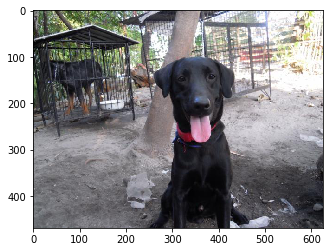

Dogs Detected!
It looks like a Newfoundland


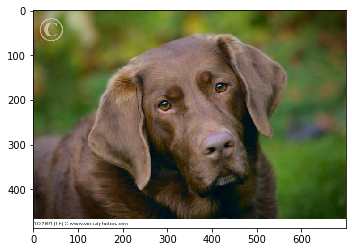

Dogs Detected!
It looks like a Kerry_blue_terrier


In [44]:
import os
def app(img_path):
    ## handle cases for a human face, dog, and neither
    if os.path.isfile(img_path):
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()
        if dog_detector(img_path) is True:

            prediction = predict_breed_transfer(model_transfer, clean_dog, img_path)
            print("Dogs Detected!\nIt looks like a {0}".format(prediction))  
        elif face_detector(img_path) > 0:
            prediction = predict_breed_transfer(model_transfer, clean_dog, img_path)
            print("Hello, human!\nIf you were a dog..You may look like a {0}".format(prediction))
        else:
            print("Error! Can't detect anything..")

for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    app(img_path)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

With 20 epochs accuracy is 74%. So as expecte increasing the number of epochs increase the acuuracy of prediction.

Three specific points of improvements based on the test on sample images are:

- Improve to detect variations in size images seems to be hard to learn.
- The algorithm did not detect a human (or a dog) in the picture of Sachin Tendulkar. The image has his face turned towards the side. This might be the reason why the algorithm failed.
- The model seems to be confused when presented with an image with 2 dogs of different breeds in it. The algorithm cannot determine if there are multiple dogs in the picture.

['lfw/Dwayne_Wade/Dwayne_Wade_0001.jpg'
 'lfw/Chandrika_Kumaratunga/Chandrika_Kumaratunga_0001.jpg'
 'lfw/Alberto_Fujimori/Alberto_Fujimori_0001.jpg'
 'lfw/Alberto_Fujimori/Alberto_Fujimori_0002.jpg'
 'lfw/Edward_Norton/Edward_Norton_0002.jpg']


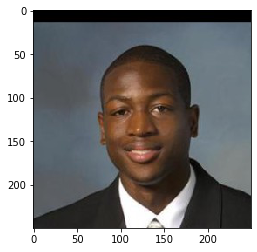

Hello, human!
If you were a dog..You may look like a Bloodhound


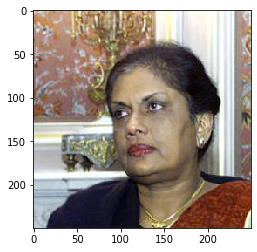

Hello, human!
If you were a dog..You may look like a Irish_water_spaniel


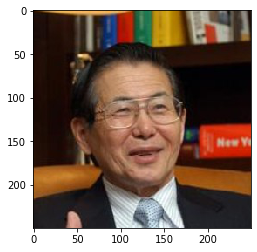

Hello, human!
If you were a dog..You may look like a Irish_water_spaniel


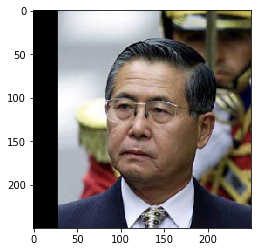

Hello, human!
If you were a dog..You may look like a Lowchen


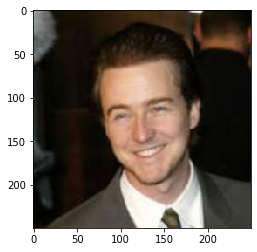

Hello, human!
If you were a dog..You may look like a German_shepherd_dog


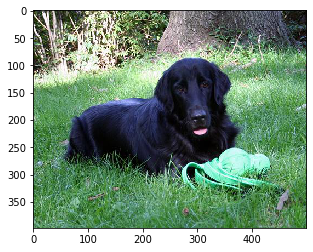

Dogs Detected!
It looks like a Yorkshire_terrier


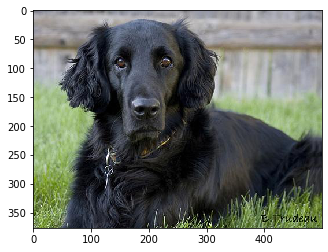

Dogs Detected!
It looks like a Yorkshire_terrier


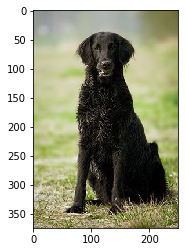

Dogs Detected!
It looks like a Yorkshire_terrier


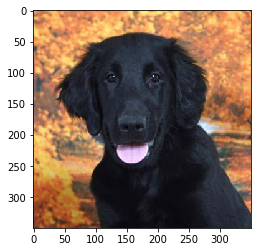

Dogs Detected!
It looks like a Yorkshire_terrier


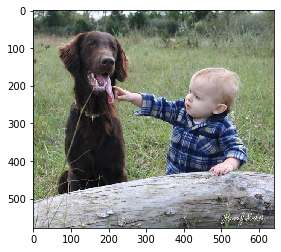

Dogs Detected!
It looks like a English_cocker_spaniel


In [46]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below



import numpy as np
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))
print(human_files[:5])
for file in np.hstack((human_files[:5], dog_files[:5])):
    app(file)

### Deleting all your models and instances

When you are _completely_ done with this project and do **not** ever want to revisit this notebook, you can choose to delete all of your SageMaker notebook instances and models by following [these instructions](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html). Before you delete this notebook instance, I recommend at least downloading a copy and saving it, locally.